In [63]:
%load_ext autoreload
%autoreload 2

from pathlib import Path
import numpy as np
import pandas as pd
from scipy.stats import halfnorm

from sklearn.datasets import make_blobs
from scipy.spatial.distance import pdist, squareform
from sklearn.neighbors import LocalOutlierFactor
from scipy.stats import gaussian_kde

from mi_density import *

import matplotlib.pyplot as plt
import matplotlib as mpl
import matplotlib.ticker as ticker
# adjust legend axis spacing
# "legend.borderaxespad": 1.0,
plt.rcParams.update({
    "legend.borderaxespad": 0.75,
})

import mpl_style

# Add the font file
fpath = Path("/Users/andrewf/Library/Fonts/dejavu-sans.condensed.ttf")
mpl.font_manager.fontManager.addfont(fpath)
if fpath.exists():
    # Add the font to the font manager
    mpl.font_manager.fontManager.addfont(str(fpath))
    
    # Create font properties object
    prop = mpl.font_manager.FontProperties(fname=str(fpath))
    font_name = prop.get_name()
    
    # Set as default
    plt.rcParams['font.family'] = 'sans-serif'
    plt.rcParams['font.sans-serif'] = [font_name]
    
    # Set specific text properties 
    # For newer matplotlib versions
    mpl.rc('font', **{'family': 'sans-serif', 'sans-serif': [font_name]})
    
    def apply_condensed_font(fig):
        for ax in fig.axes:
            # Apply to all text elements on the axes
            for text in ax.texts:
                text.set_fontproperties(prop)
            
            # Apply to title and axis labels
            ax.title.set_fontproperties(prop)
            ax.xaxis.label.set_fontproperties(prop)
            ax.yaxis.label.set_fontproperties(prop)
            
            # Apply to tick labels
            for label in ax.get_xticklabels():
                label.set_fontproperties(prop)
            for label in ax.get_yticklabels():
                label.set_fontproperties(prop)
            
            # Apply to legend if it exists
            legend = ax.get_legend()
            if legend:
                # Apply to legend title
                if legend.get_title():
                    legend.get_title().set_fontproperties(prop)
                
                # Apply to legend text
                for text in legend.get_texts():
                    text.set_fontproperties(prop)

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [64]:

def set_blob_params(bottom_pos=0.0):

    blob_params = [
        # {"center": [0.6, 0.6], "std": 0.1, "random_state": 10},
        # {"center": [-1.5, -1.5], "std": 0.1, "random_state": 10},
        {"center": [bottom_pos, bottom_pos], "std": 0.1, "random_state": 10},
        {"center": [1, 1], "std": 0.3, "random_state": 5},
        {"center": [2, 2], "std": 0.5, "random_state": 6},
        {"center": [2, 1], "std": 0.1, "random_state": 11},
    ]

    return blob_params


# Generate all blobs and concatenate
def get_X(blob_params):

    X = np.vstack(
        [
            make_blobs(
                n_samples=20,
                centers=[params["center"]],
                cluster_std=params["std"],
                random_state=params["random_state"],
            )[0]
            for params in blob_params
        ]
    )

    # the sort order is applied so that points of higher density are plotted last and thus
    # will appear on top of points of lower density in the scatter plot.

    # sort_order = np.array([18, 19, 15, 3, 13, 0, 11, 8, 5, 17, 9, 10, 4, 2, 6, 1, 14, 7, 
    #                     12, 16, 33, 30, 34, 23, 26, 38, 27, 29, 20, 37, 24, 35, 28, 39,
    #                     22, 32, 31, 36, 21, 25, 58, 49, 54, 56, 50, 53, 55, 47, 41, 57,
    #                     43, 42, 44, 52, 40, 46, 48, 59, 45, 51, 60, 79, 71, 70, 72, 68,
    #                     75, 62, 64, 73, 67, 61, 78, 69, 66, 74, 63, 76, 65, 77])
    # X = X[sort_order]

    # shuffle the data
    return X

sigmas = [0.1, 0.3, 0.5, 0.1]

# Create x values
x_pdf = np.linspace(0, 1.5, 200)

# Initialize sum of PDFs
pdf_sum = np.zeros_like(x_pdf)

# Plot each distribution and add to sum
for i, sigma in enumerate(sigmas):
    pdf = halfnorm.pdf(x_pdf, scale=sigma)
    pdf_sum += pdf/np.max(pdf)

pdf_sum = pdf_sum / len(sigmas)
pdf_sum /= np.max(pdf_sum)


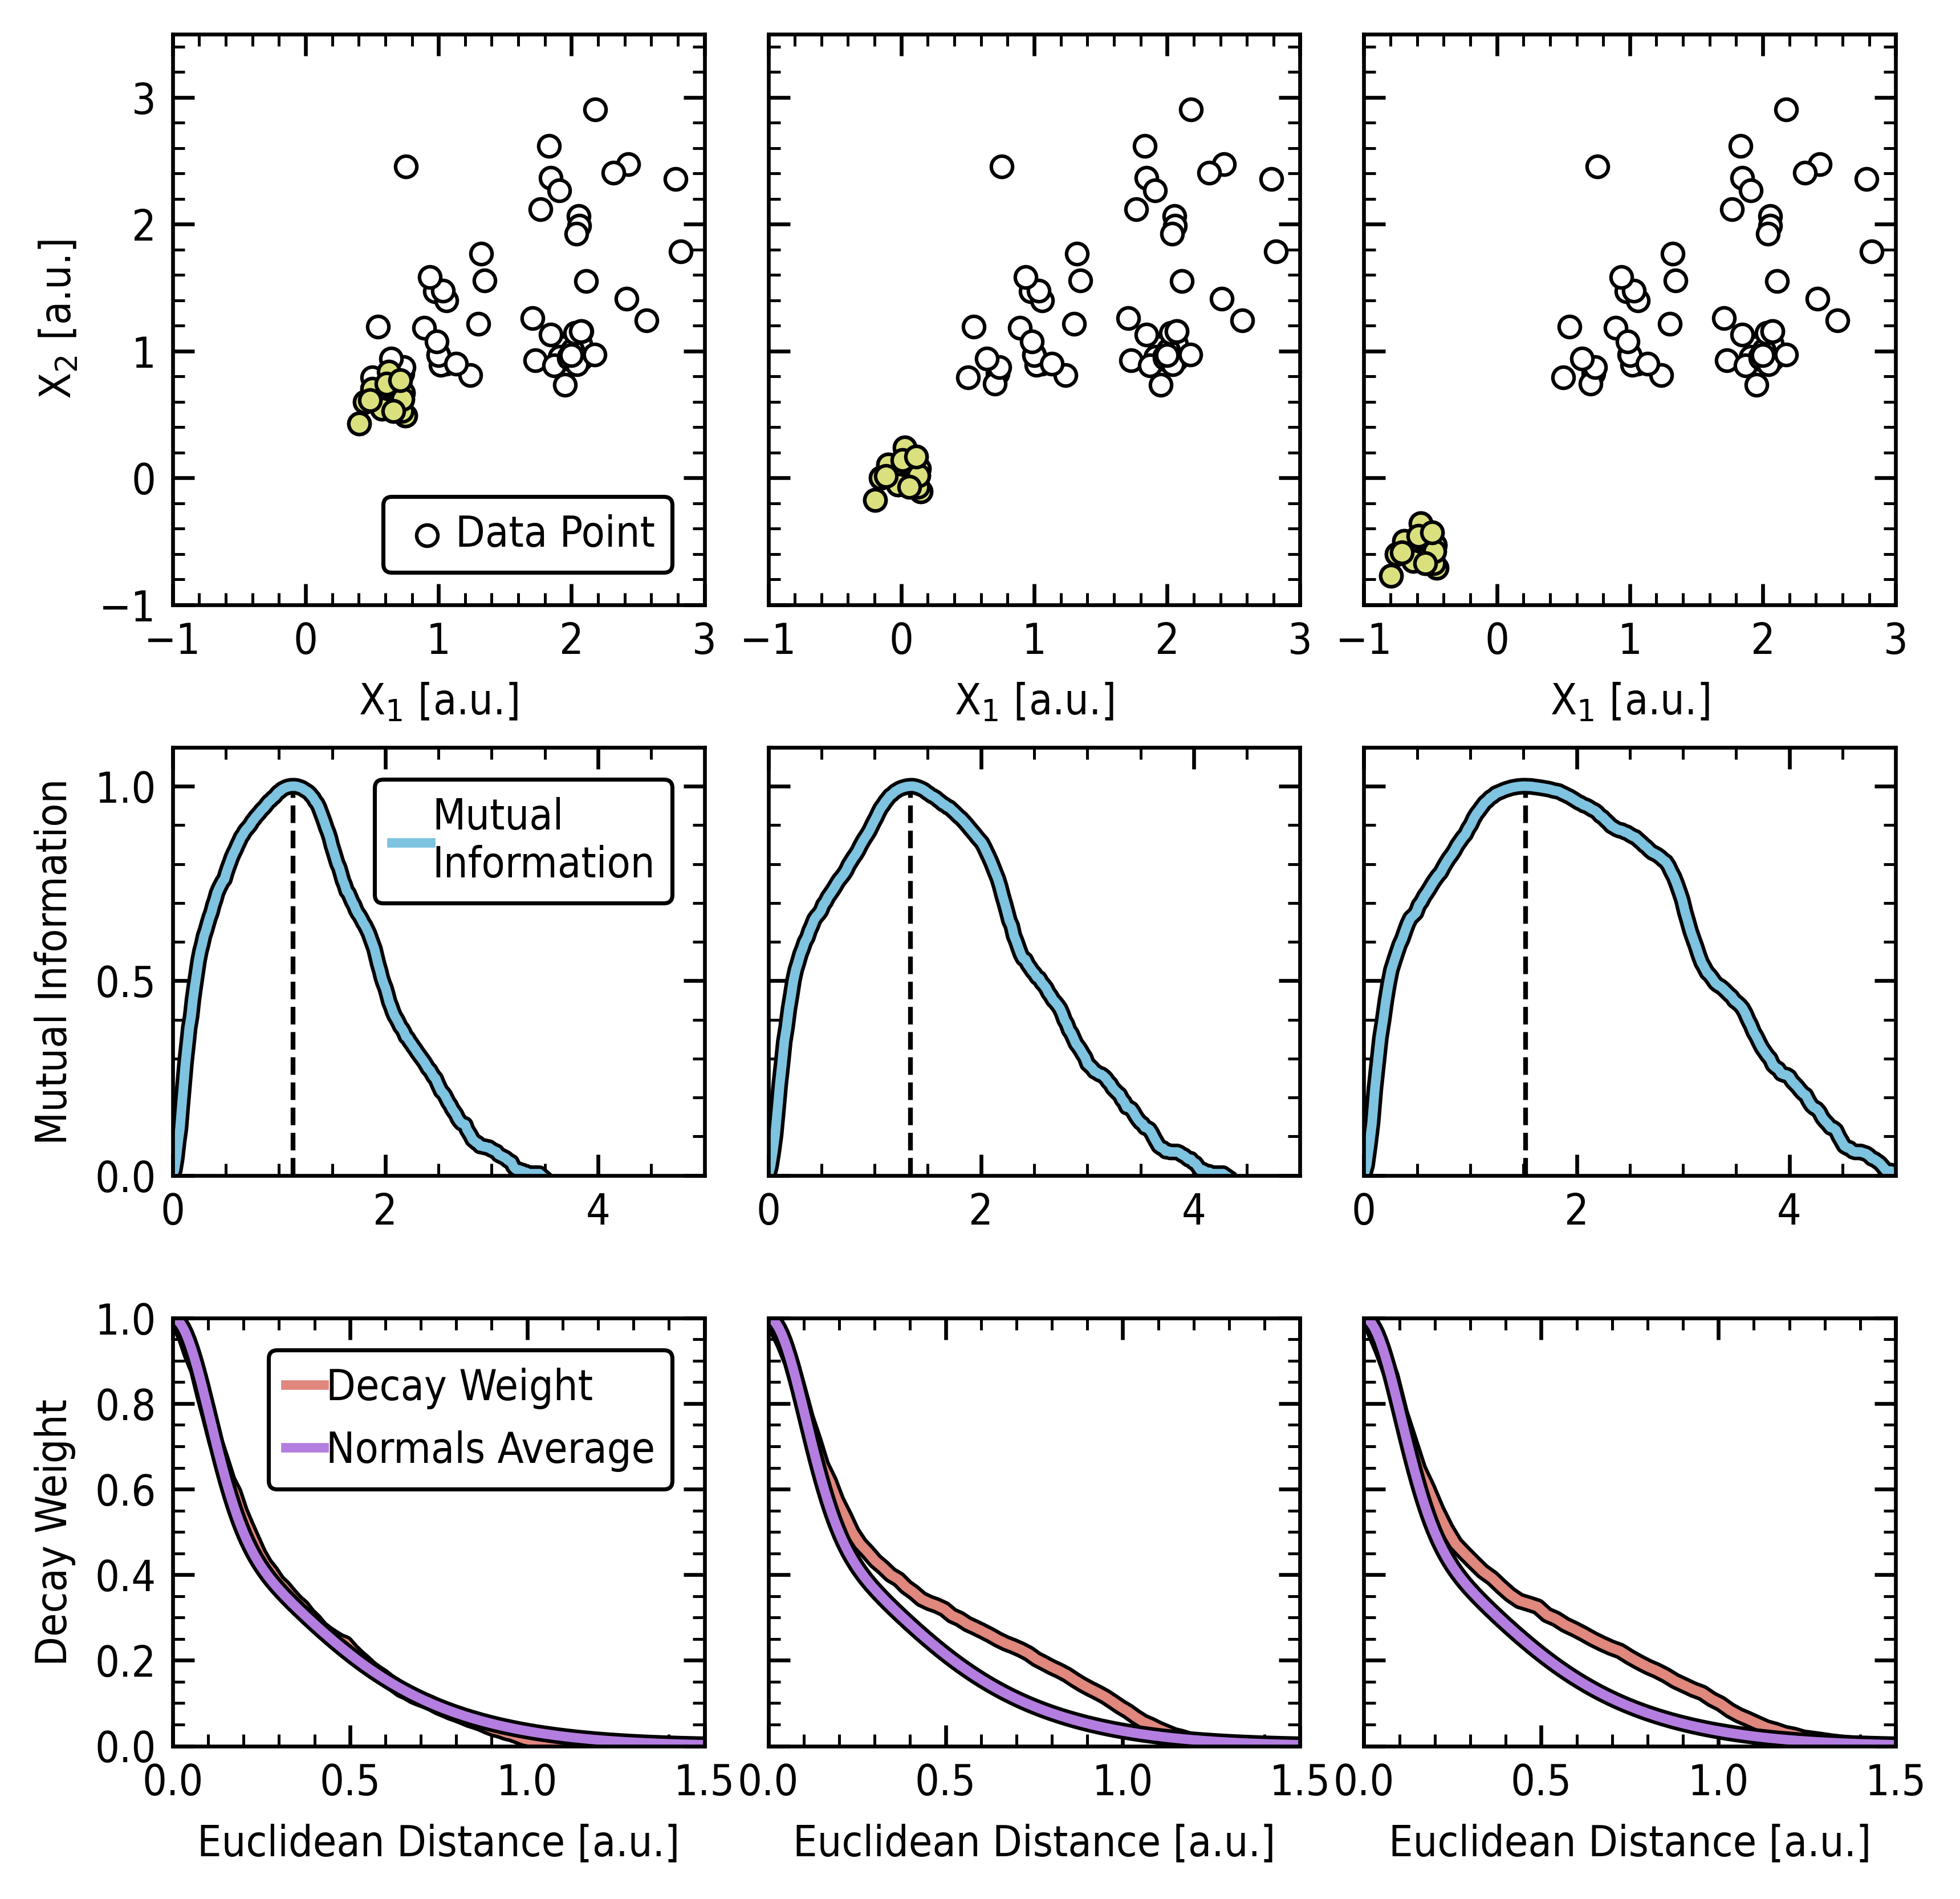

In [83]:
fig, ax = plt.subplots(ncols=3, nrows=3, figsize=(6.5, 6.5), dpi=600, height_ratios=[1, 0.75, 0.75])

# set hspace and wspace
fig.subplots_adjust(hspace=0.3, wspace=0.12)

for i, pos in enumerate([0.6, 0.0, -0.6]):
    blob_params = set_blob_params(pos)
    X = get_X(blob_params)
    X_dm = squareform(pdist(X, metric="euclidean"))

    # Create the scatter plot
    ax[0, i].scatter(X[:, 0], X[:, 1], s=20,lw=0.75, fc='w', ec='k')
    ax[0, i].scatter(X[:20, 0], X[:20, 1], s=20, lw=0.75, fc='#DAE07E', ec='k')
    ax[0,i].set_ylim(-1.0, 3.5)
    ax[0,i].set_xlim(-1.0, 3)
    ax[0,i].set_xticks([-1, 0, 1, 2, 3])
    ax[0,i].set_xlabel("X$_1$ [a.u.]")

    num_thresh = 200
    cutoff, mi_profile = get_MI_profile(X_dm, num_thresh)
    minov_dens = compute_mi_density(X_dm, cutoff, mi_profile)
    minov_dens = minov_dens / minov_dens.max()  # normalize to [0, 1] for colorbar

    # set to zero after cutoff
    mask = np.linspace(0, np.max(X_dm), num_thresh) <= cutoff

    x = np.linspace(0, np.max(X_dm), num_thresh)[mask]
    y = 1-mi_profile[mask]/mi_profile[mask].max()

    ax[1, i].vlines(cutoff, 0, 1, lw=1, color="k", ls="--")
    ax[1, i].plot(np.linspace(0, np.max(X_dm), num_thresh), mi_profile, lw=3.5, color="k")
    ax[1, i].plot(np.linspace(0, np.max(X_dm), num_thresh), mi_profile/np.max(mi_profile), color="#7EC3E0", lw=2)
    ax[1,i].set_ylim(0.0, 1.1)
    ax[1, i].set_yticks([0.0, 0.5, 1.0])
    ax[1,i].set_xlim(0.0, 5)
    ax[1, i].set_xticks([0, 2, 4])

    ax[2,i].plot(np.linspace(0, np.max(X_dm), num_thresh)[mask], (1-(mi_profile/np.max(mi_profile))[mask]), lw=3.5, color="k", zorder=1)
    ax[2,i].plot(np.linspace(0, np.max(X_dm), num_thresh)[mask], (1-(mi_profile/np.max(mi_profile))[mask]), lw=2, color="#E0877E", zorder=2)
    ax[2,i].plot(x_pdf, pdf_sum, lw=3.5, color="k")
    ax[2,i].plot(x_pdf, pdf_sum, lw=2, color="#B47EE0")
    ax[2,i].set_ylim(0.0, 1.0)
    ax[2,i].set_xlim(0.0, 1.5)
    ax[2,i].set_xlabel("Euclidean Distance [a.u.]")

    if i == 0:
        ax[0, i].set_ylabel("X$_2$ [a.u.]")
        ax[1, i].set_ylabel("Mutual Information")
        ax[2, i].set_ylabel("Decay Weight")

    if i > 0:
        ax[0,i].set_yticklabels([])
        ax[1,i].set_yticklabels([])
        ax[2,i].set_yticklabels([])


ax[0,0].scatter([],[], s=20, lw=0.75, fc='w', ec='k', label='Data Point')
legend = ax[0,0].legend(frameon=True, framealpha=1, edgecolor="k", loc='lower right')
legend.get_frame().set_linewidth(0.85)

ax[1,0].plot([],[], color='#7EC3E0', label='Mutual\nInformation')
legend = ax[1,0].legend(frameon=True, framealpha=1, edgecolor="k", loc='upper right', handlelength=0.9)
legend.get_frame().set_linewidth(0.85)

ax[2,0].plot([],[], color='#E0877E', label='Decay Weight')
ax[2,0].plot([],[], color='#B47EE0', label='Normals Average')
legend = ax[2,0].legend(frameon=True, framealpha=1, edgecolor="k", loc='upper right', handlelength=0.9)
legend.get_frame().set_linewidth(0.85)

# Set the font properties
apply_condensed_font(fig)
# Show the plot
plt.show()